In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.dates as mdates
from sklearn.decomposition import PCA

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_gbq as pd_gbq
import gc
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from matplotlib import pyplot as plt
from google.cloud import bigquery
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import roc_auc_score, roc_curve, auc
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
from sklearn.preprocessing import StandardScaler
import pickle
from tqdm.auto import tqdm
import pyarrow as pa
import pyarrow.parquet as pq
import joblib
import glob
import lightgbm as lgb
from google.cloud import storage
from pandas_profiling import ProfileReport
#from pyspark.context import SparkContext
#from pyspark.ml.linalg import Vectors
#from pyspark.ml.regression import LinearRegression
#from pyspark.sql.session import SparkSession

%reload_ext google.cloud.bigquery


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

#Train data
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `amexcds4.amextaiwan.Train`
"""

#select a.*,b.target from
#(SELECT * FROM `amexcds4.amextaiwan.amextaiwantrain`) a
#left join
#(SELECT * FROM `amexcds4.amextaiwan.trainLabels`) b
#on a.customer_ID	 = b.customer_ID;

train_all_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)


In [6]:
#Train label
bqclient = bigquery.Client()

query_string = """
SELECT * FROM `amexcds4.amextaiwan.trainLabels`
"""

dataframe_labels = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(
        # Optionally, explicitly request to use the BigQuery Storage API. As of
        # google-cloud-bigquery version 1.26.0 and above, the BigQuery Storage
        # API is used by default.
        create_bqstorage_client=True,
    )
)

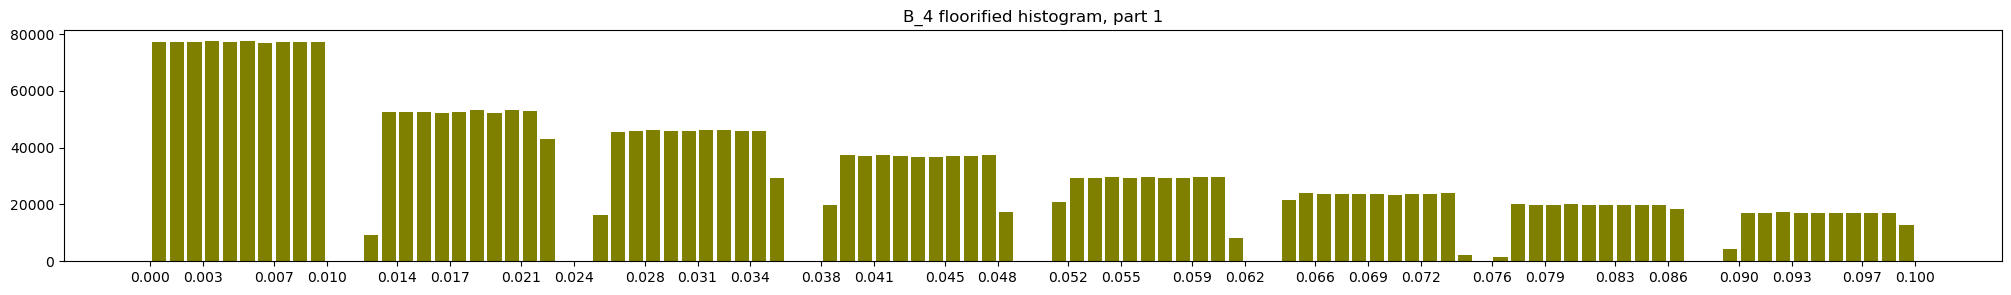

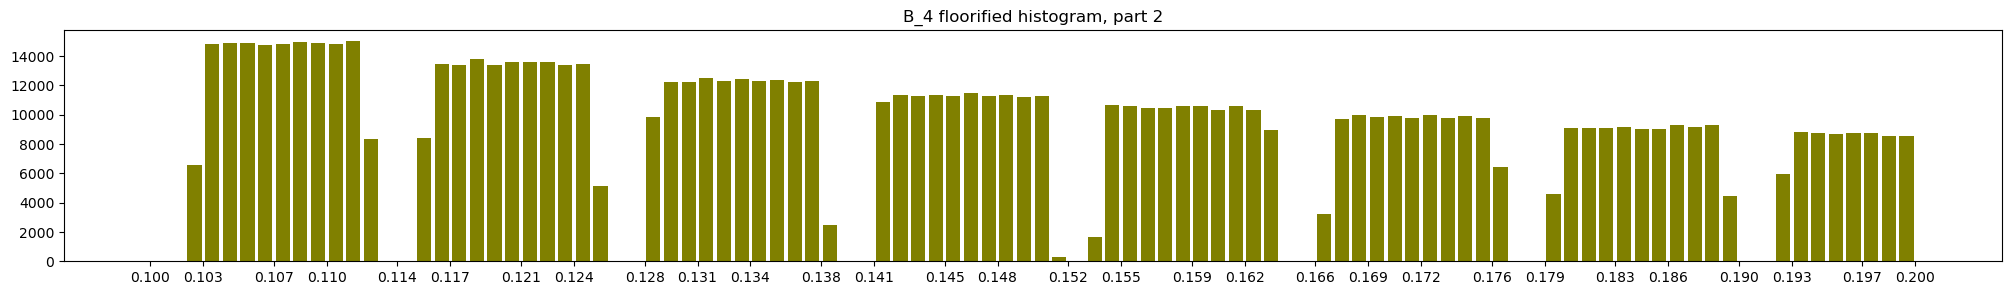

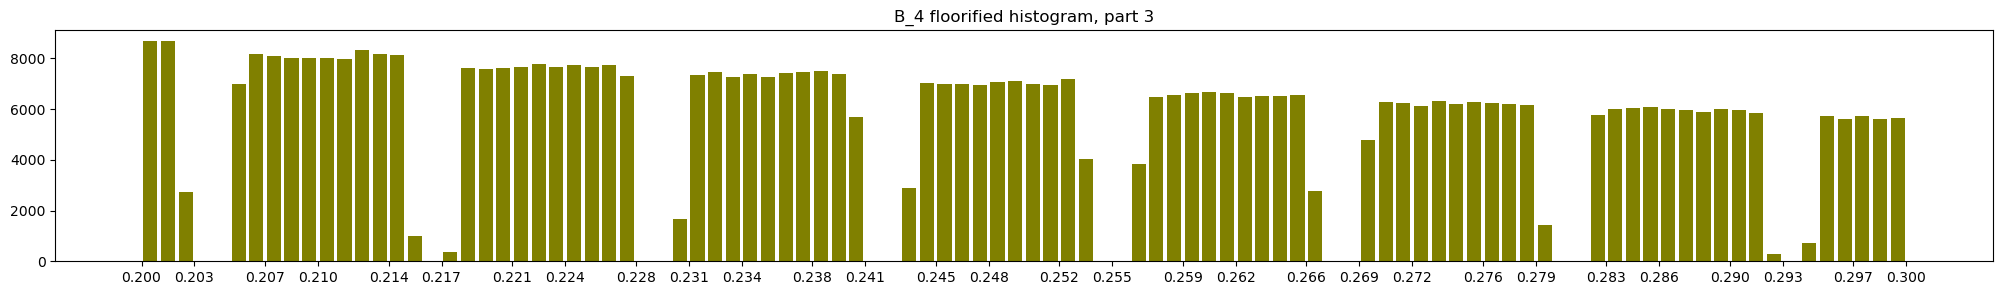

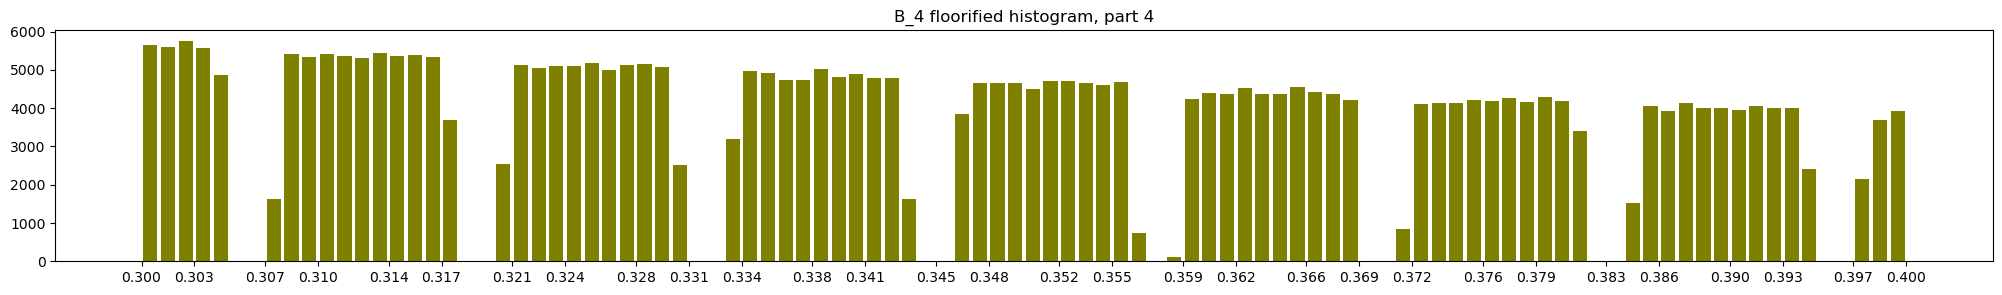

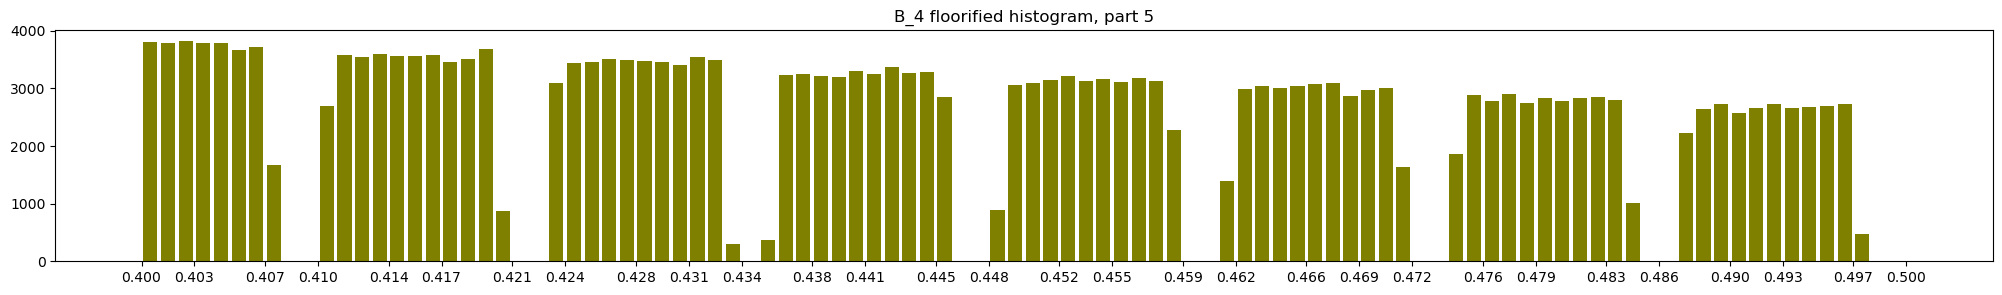

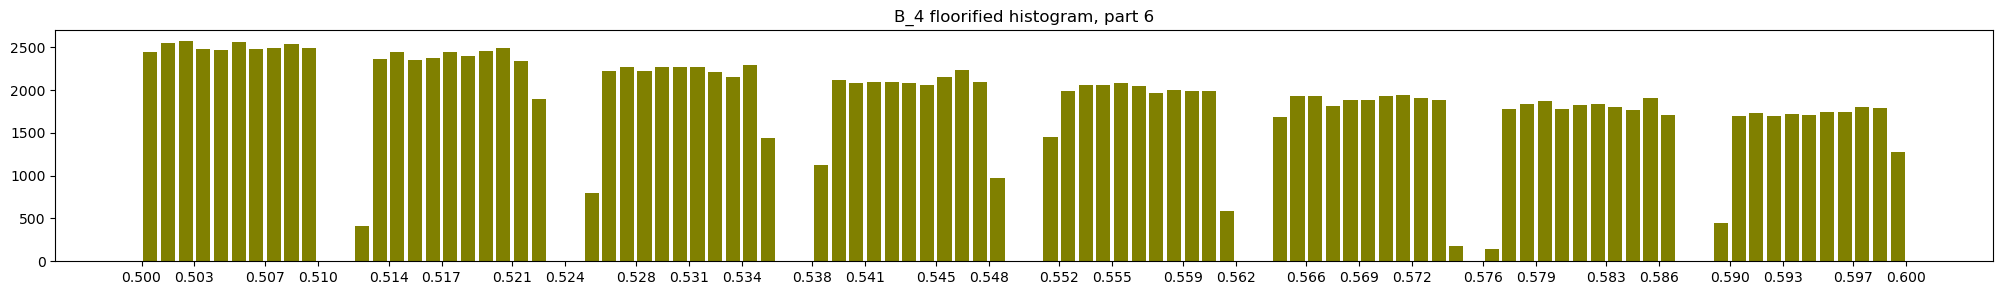

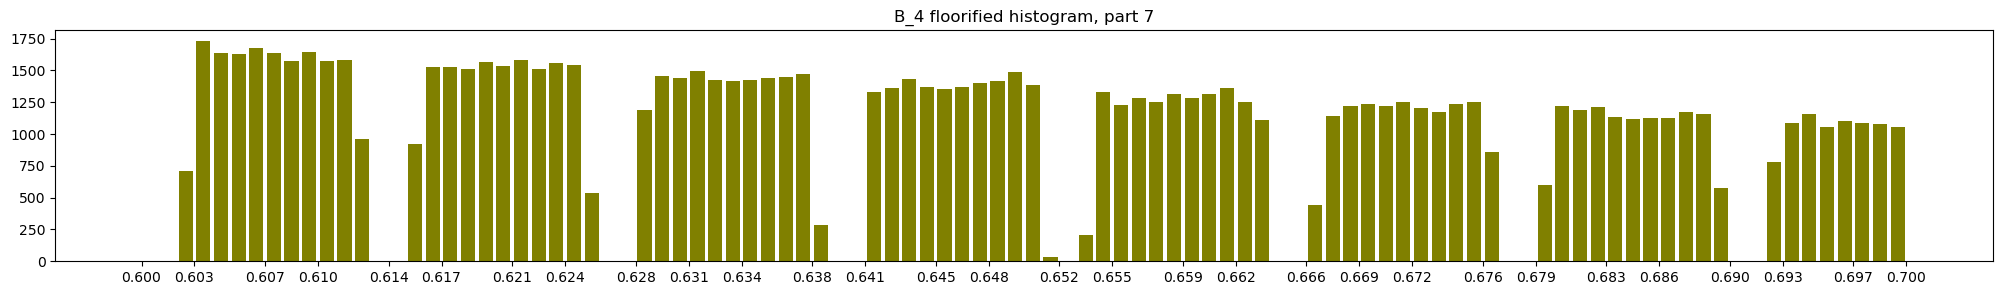

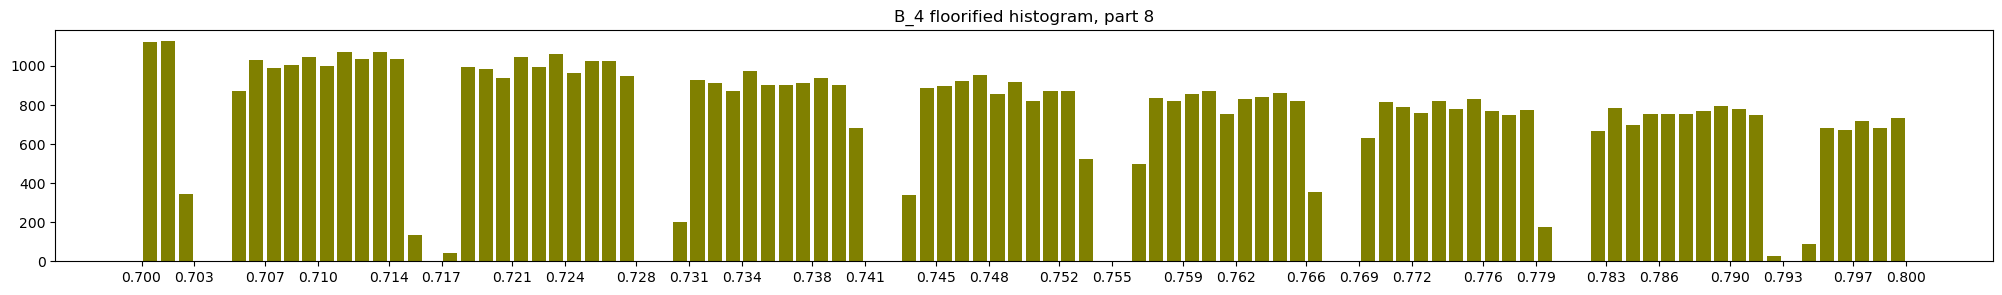

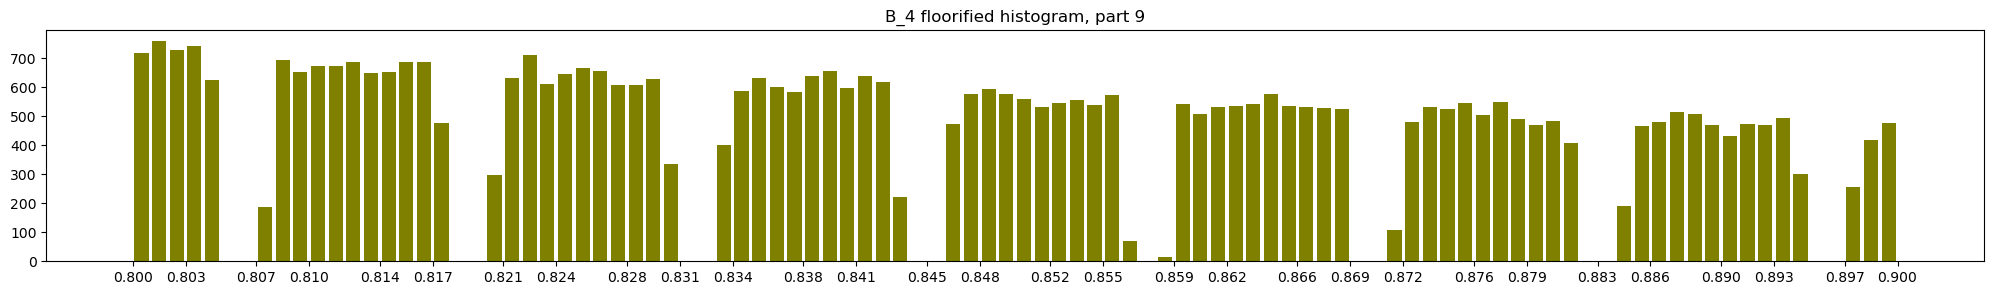

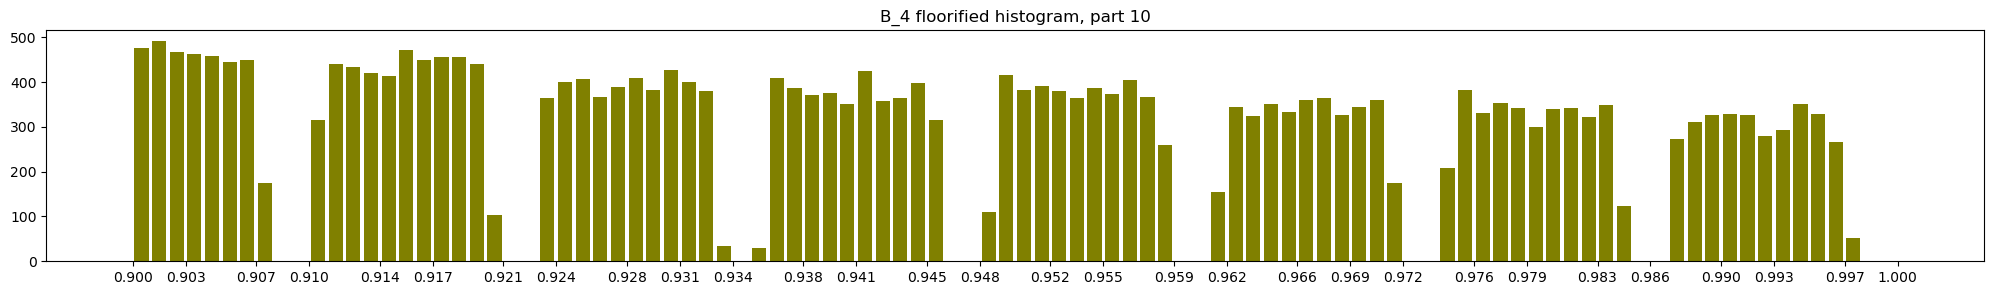

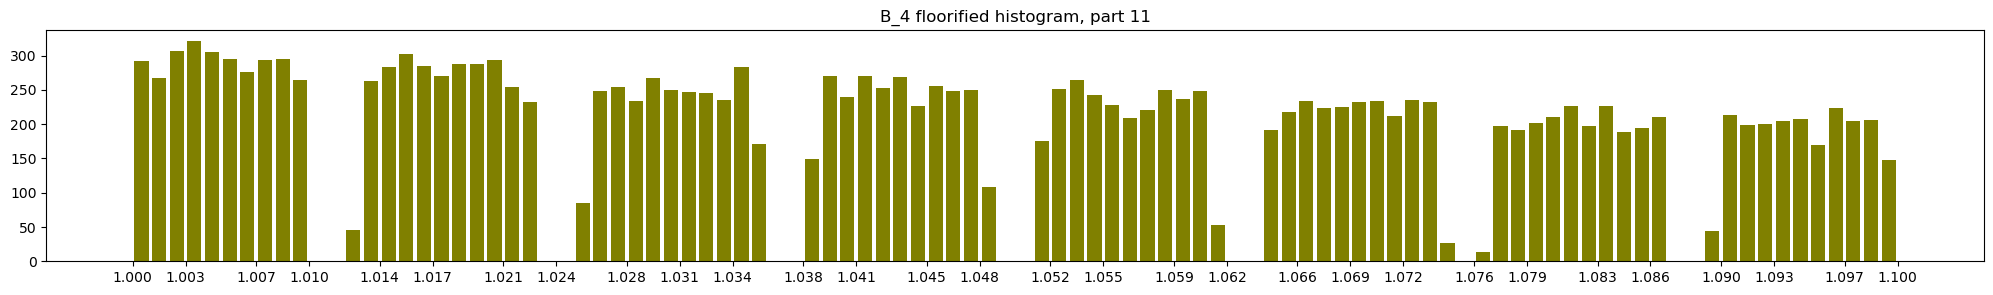

In [8]:
y = train_all_df['B_4']
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(25, 3))
    plt.hist(y, bins=np.linspace(i, i+0.1, 101), rwidth=0.8, color='olive')
    plt.xticks(np.round(np.linspace(i, i+0.1, 30), 3))
    plt.title(f"B_4 floorified histogram, part {int(i*10+1)}")
    plt.show()

In [9]:
def get_sampling_rate(var, bin1, bin2):
    min1 = train_all_df[train_all_df[var]>bin1].loc[:, var].fillna(0).min()
    min2 = train_all_df[train_all_df[var]>bin2].loc[:, var].fillna(0).min()
    print(min1)
    print(min2)
    f = abs(min2- min1)
    return 1/f

get_sampling_rate('B_4', 0.010, 0.023)

0.0128205359587859
0.0256410917831741


77.99973836529979

In [10]:
def floorify_frac(x, T=1):
    """convert to int if float appears ordinal"""
    xt = (np.floor(x*T+1e-6)).fillna(-1)
    if np.max(xt)<=127:
        return xt.astype(np.int8)
    return xt.astype(np.int16) 

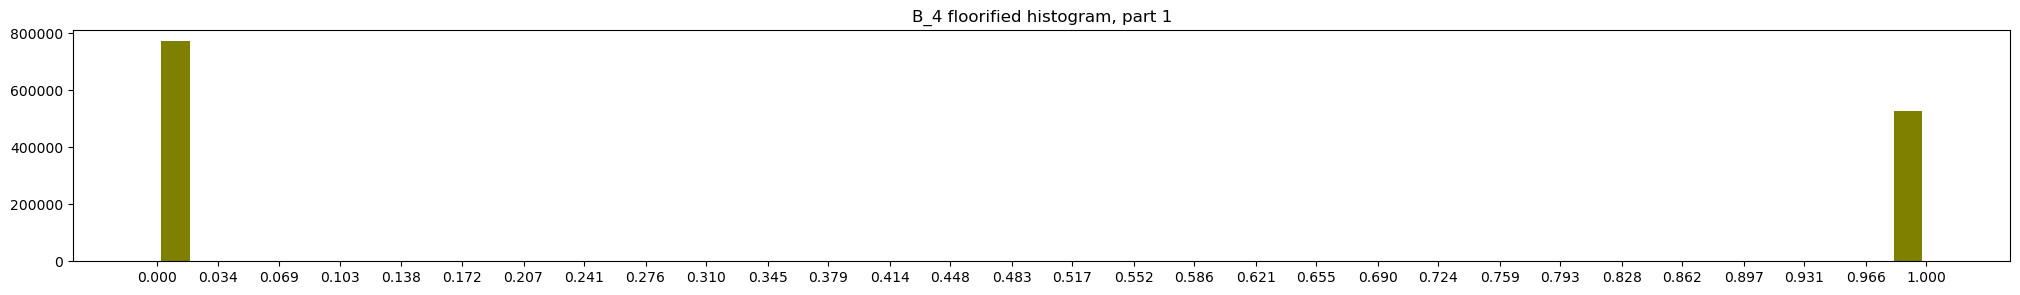

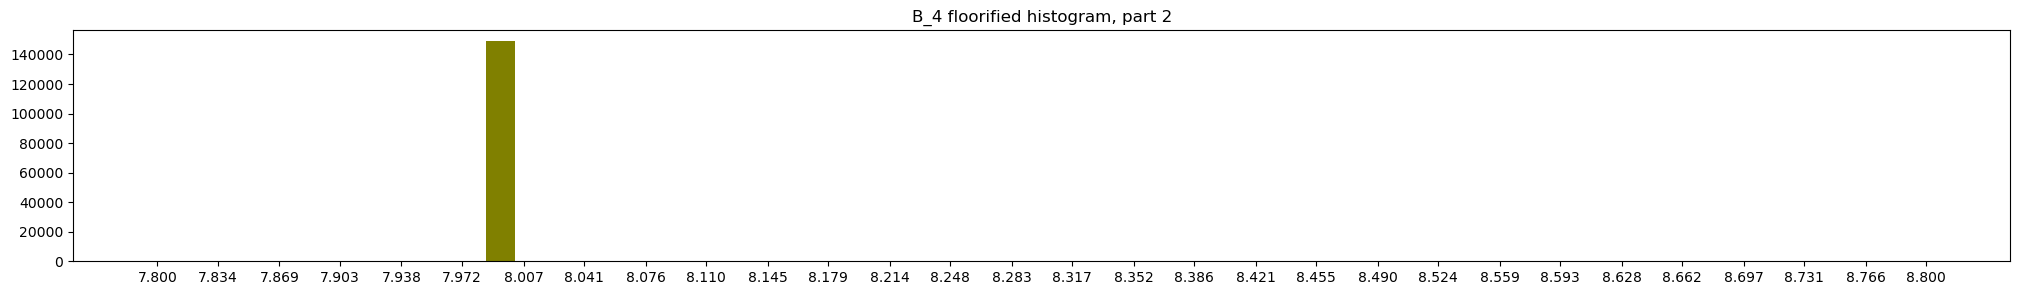

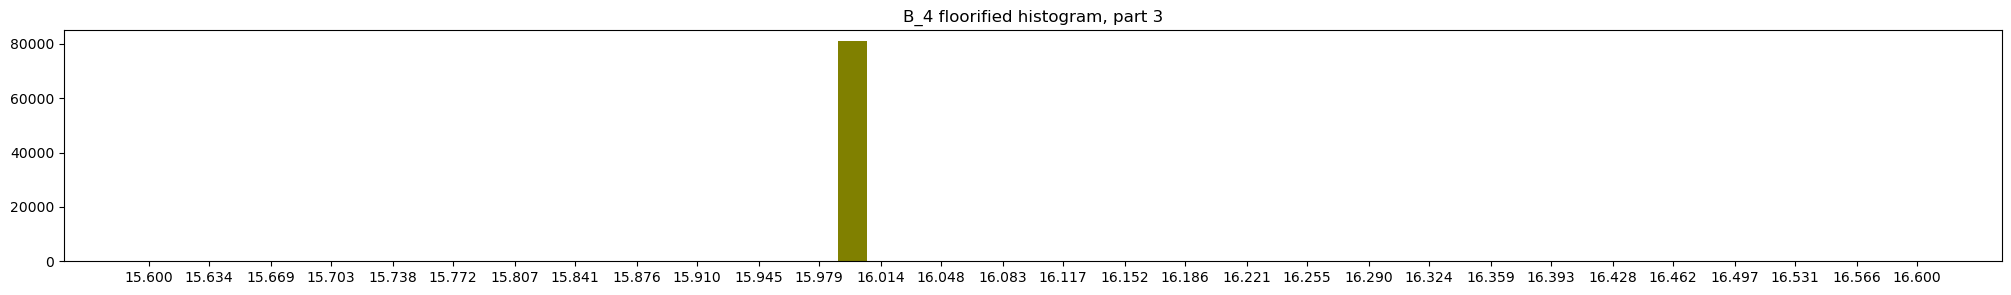

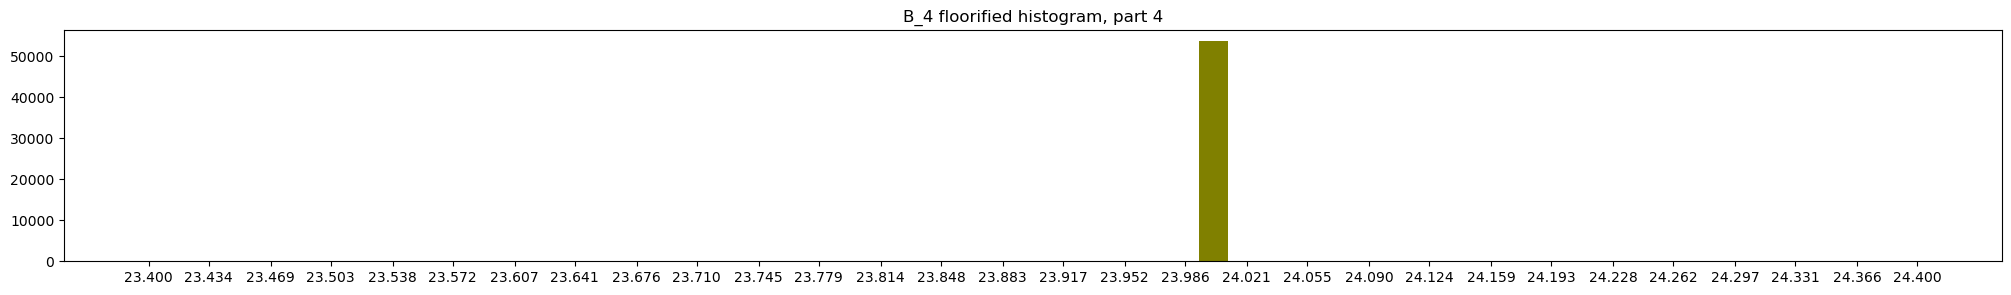

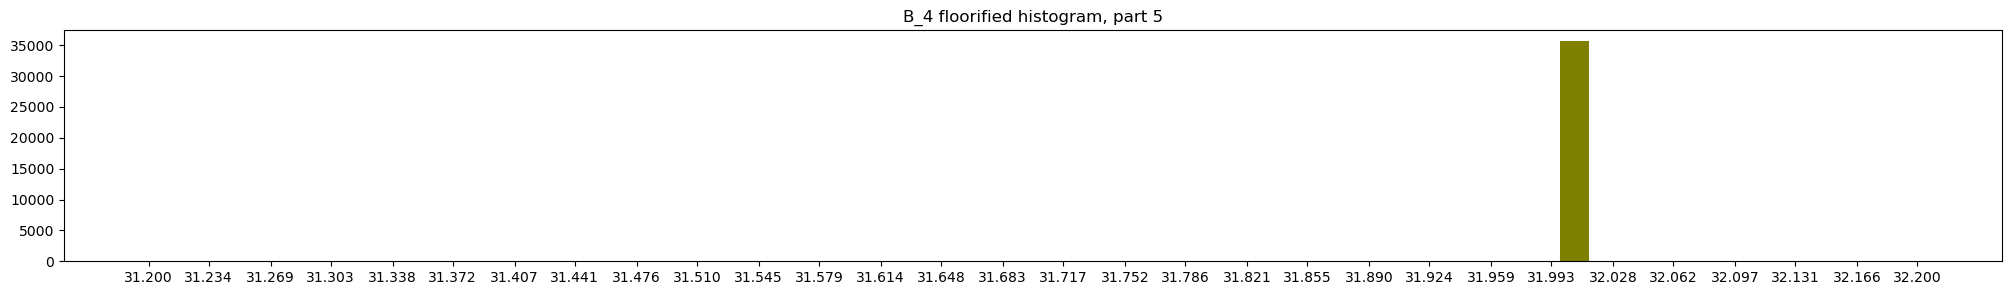

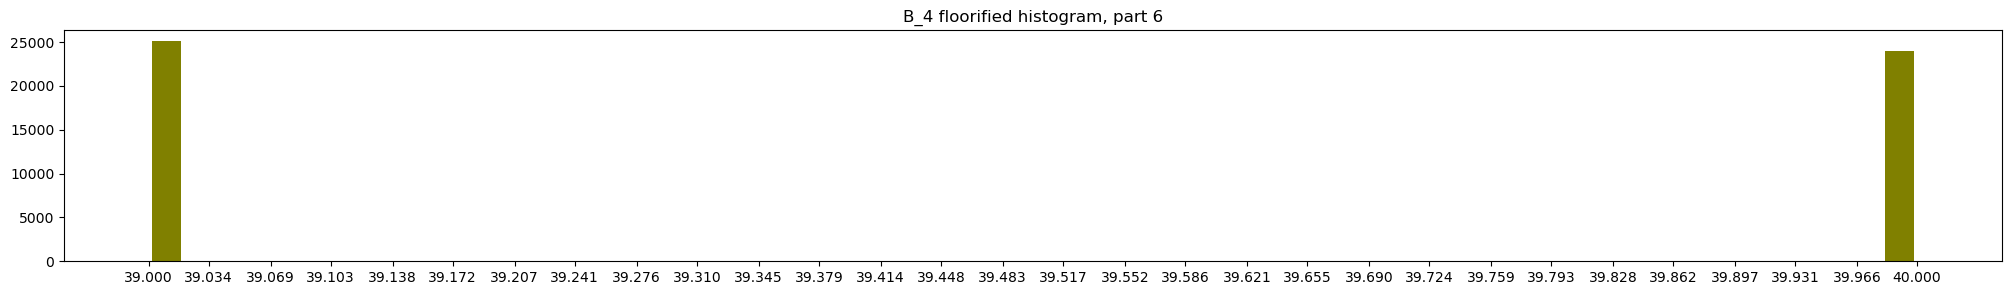

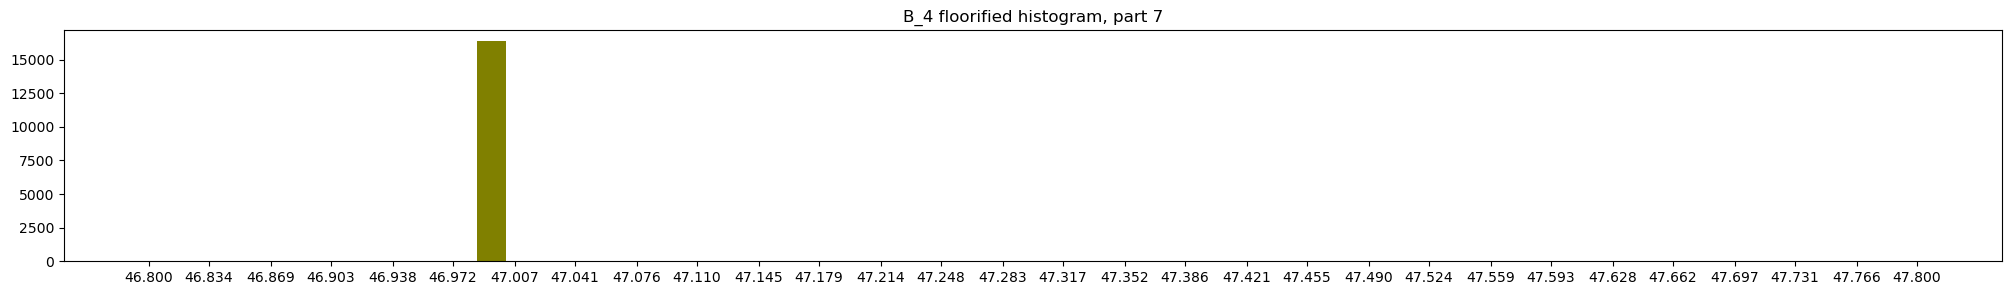

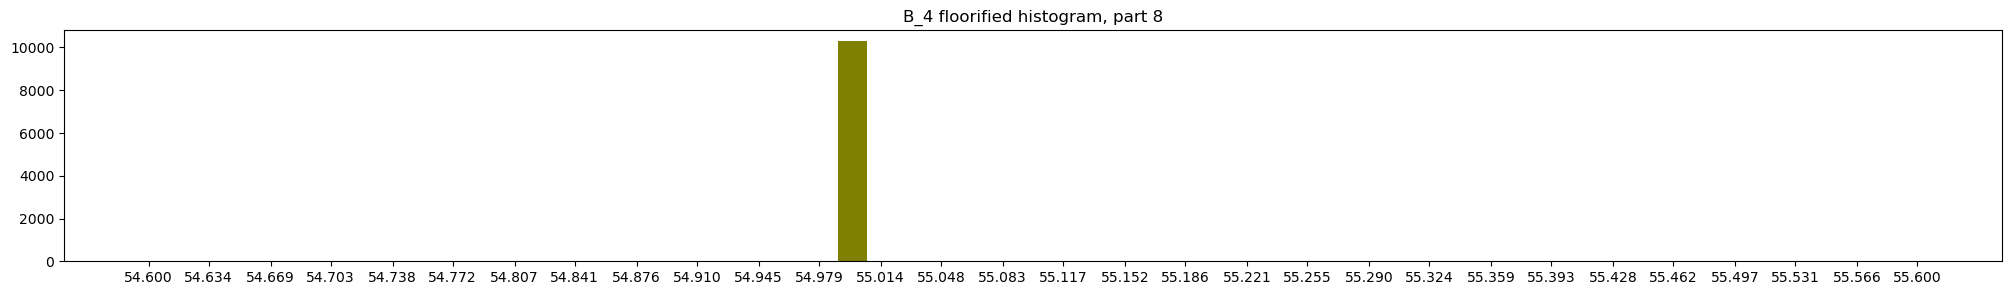

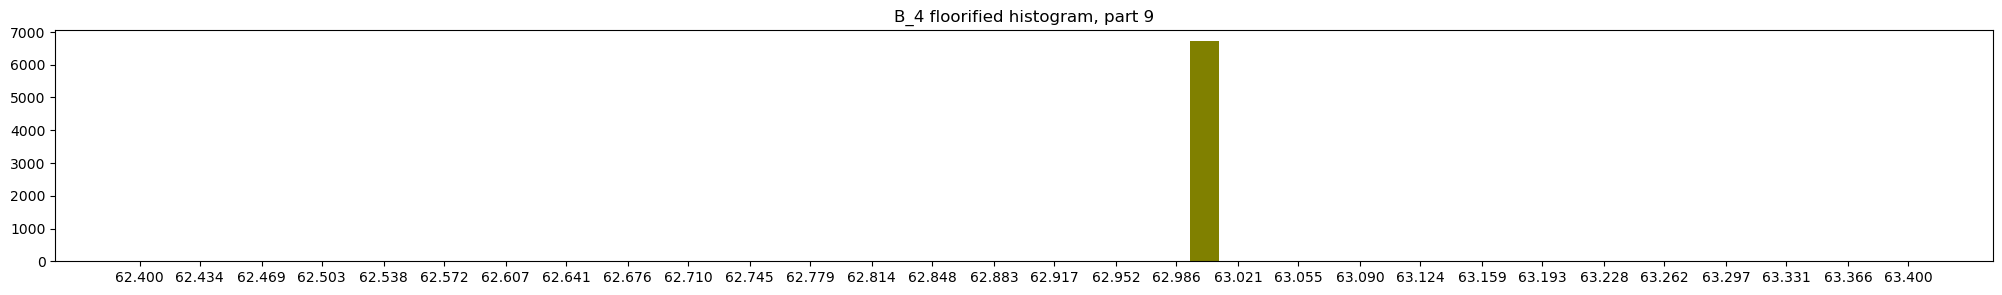

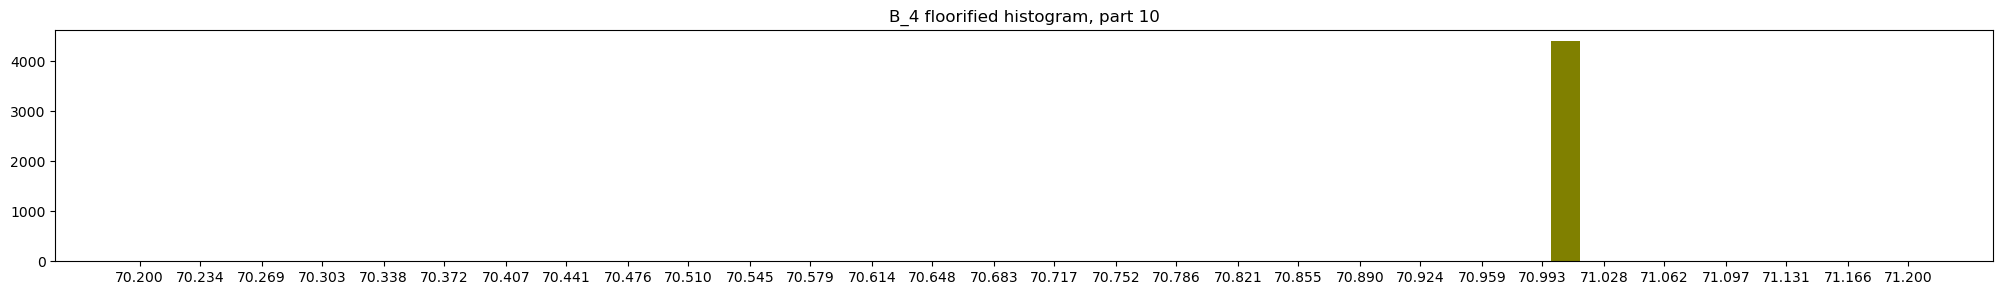

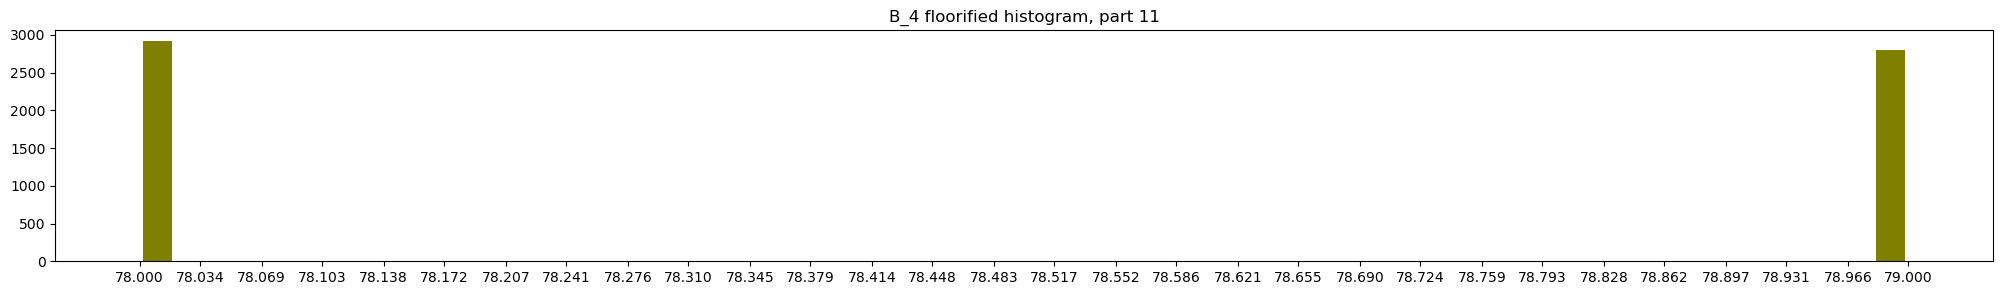

In [12]:
y = floorify_frac(train_all_df['B_4'],78)
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(25, 3))
    plt.hist(y, bins=np.linspace(i*78, i*78+1), rwidth=0.8, color='olive')
    plt.xticks(np.round(np.linspace(i*78, i*78+1, 30), 3))
    plt.title(f"B_4 floorified histogram, part {int(i*10+1)}")
    plt.show()

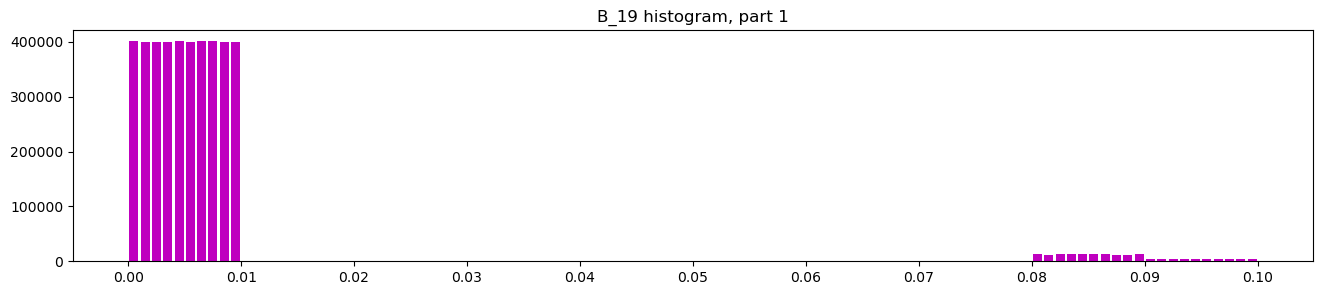

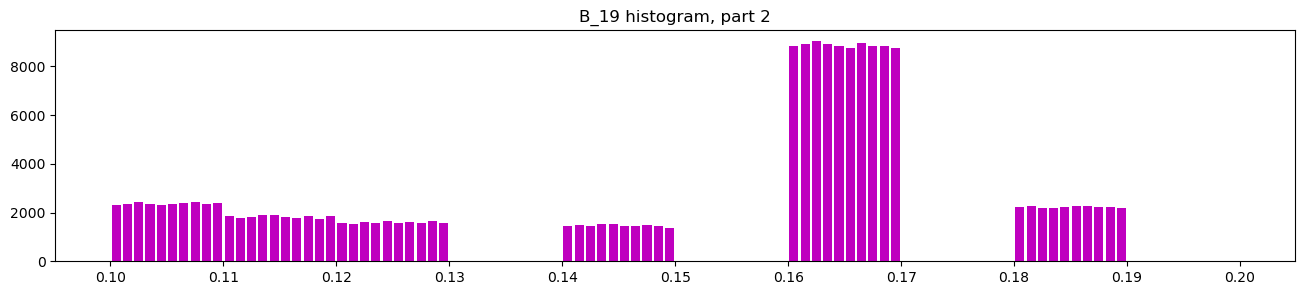

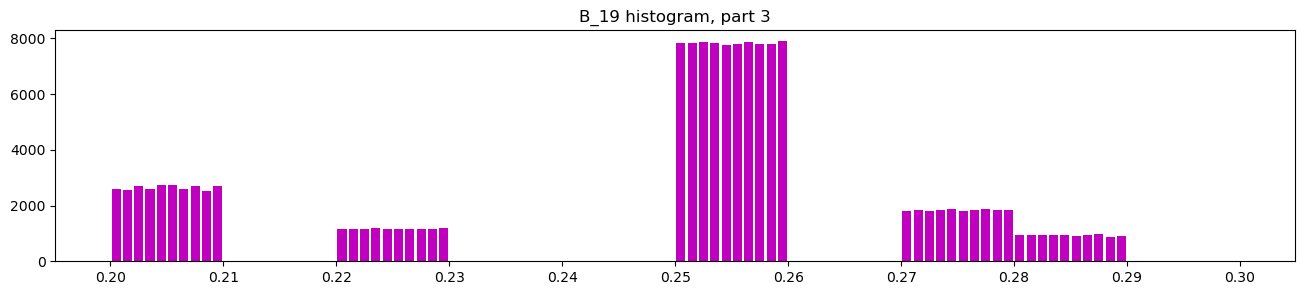

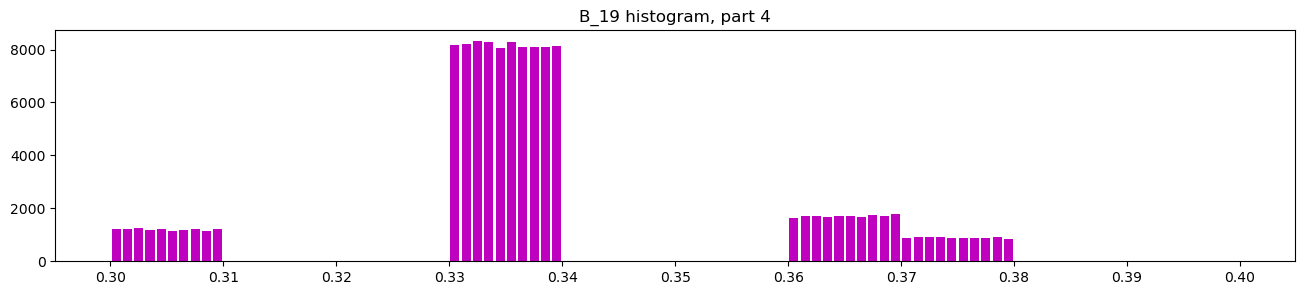

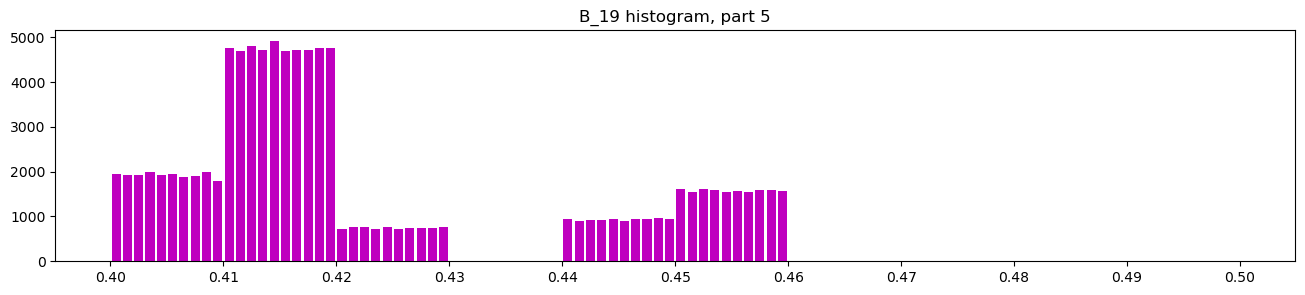

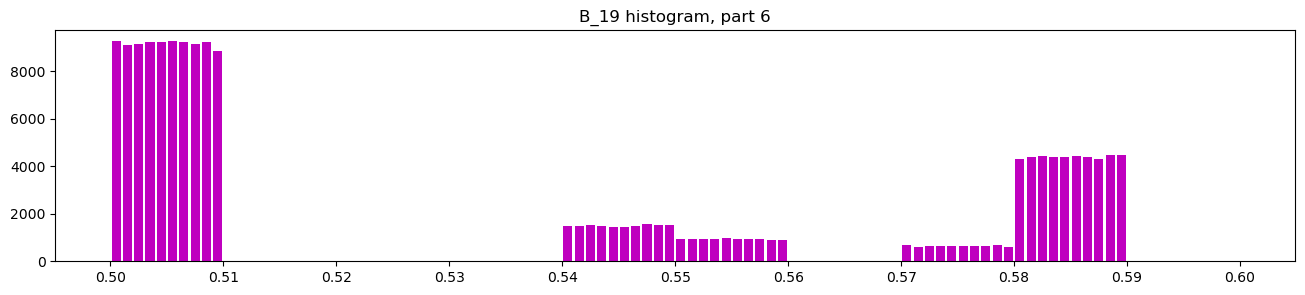

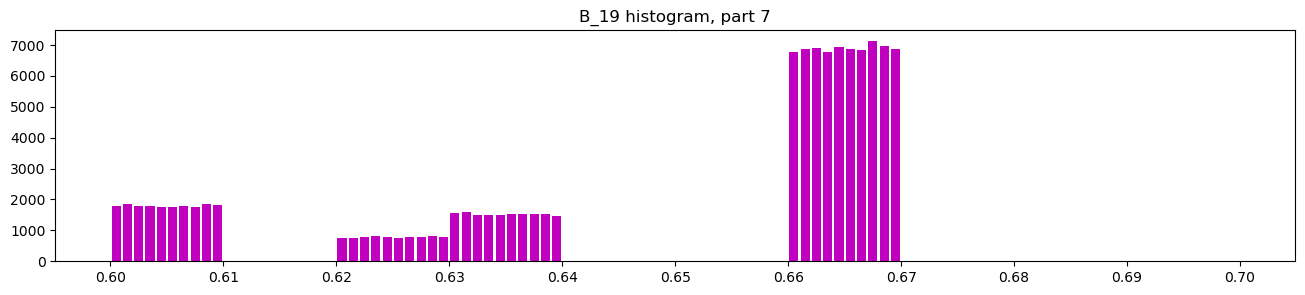

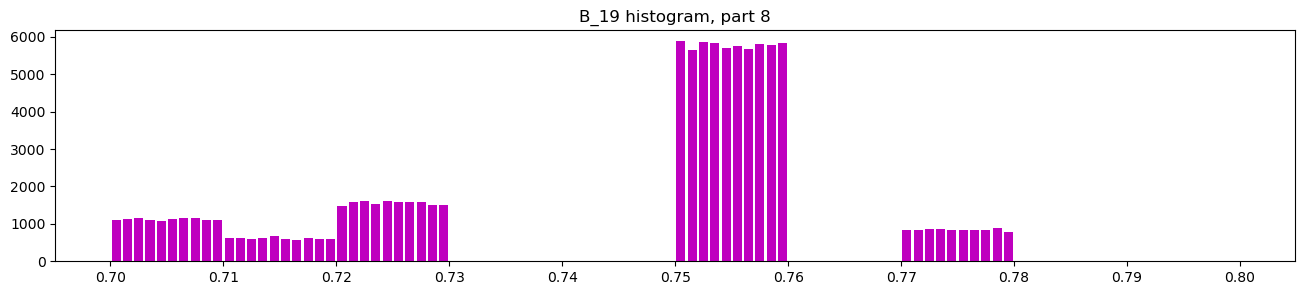

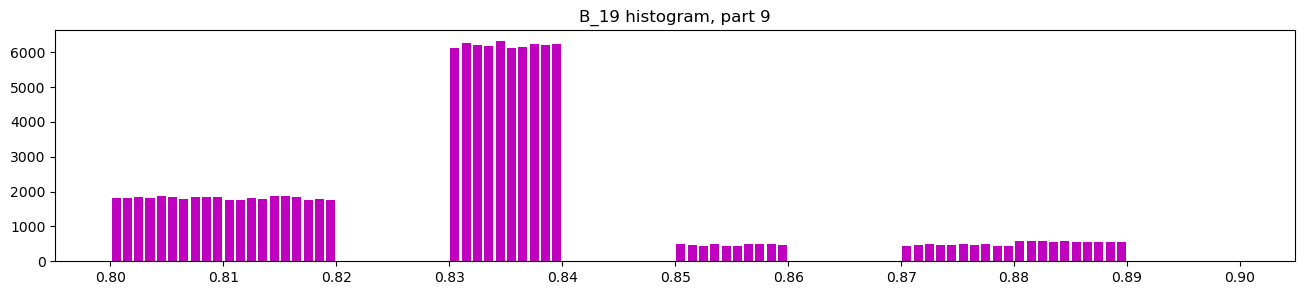

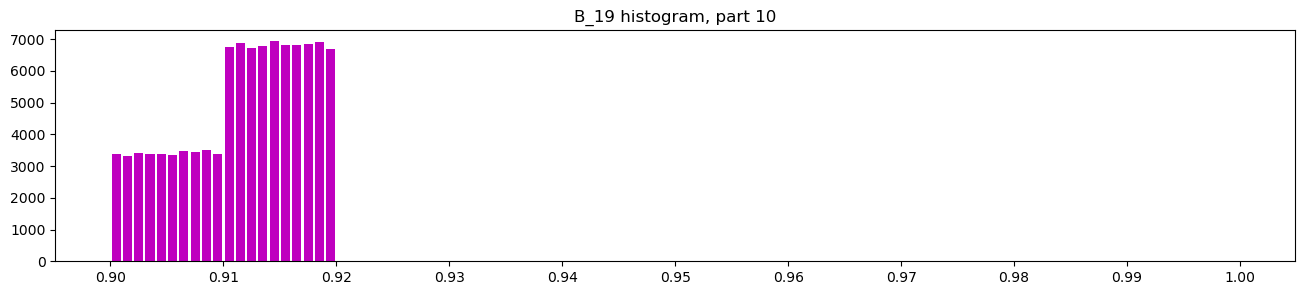

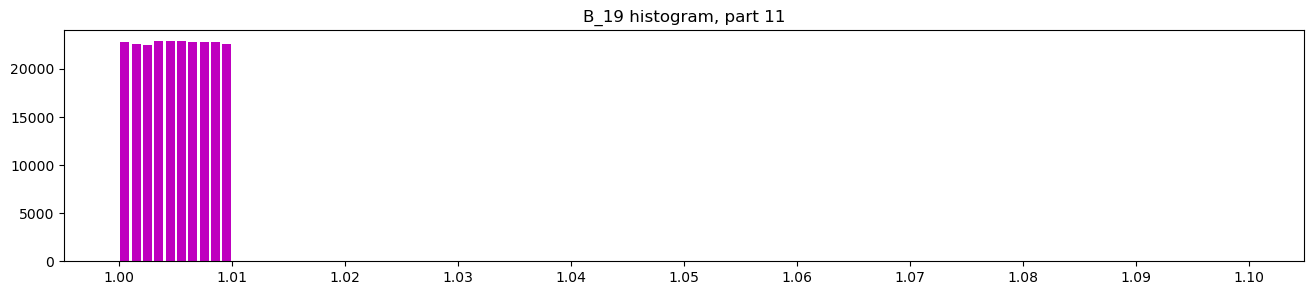

In [13]:
y = train_all_df.B_19
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(16, 3))
    plt.hist(y, bins=np.linspace(i, i+0.1, 101), rwidth=0.8, color='m')
    plt.xticks(np.linspace(i, i+0.1, 11))
    plt.title(f"B_19 histogram, part {int(i*10+1)}")
    plt.show()

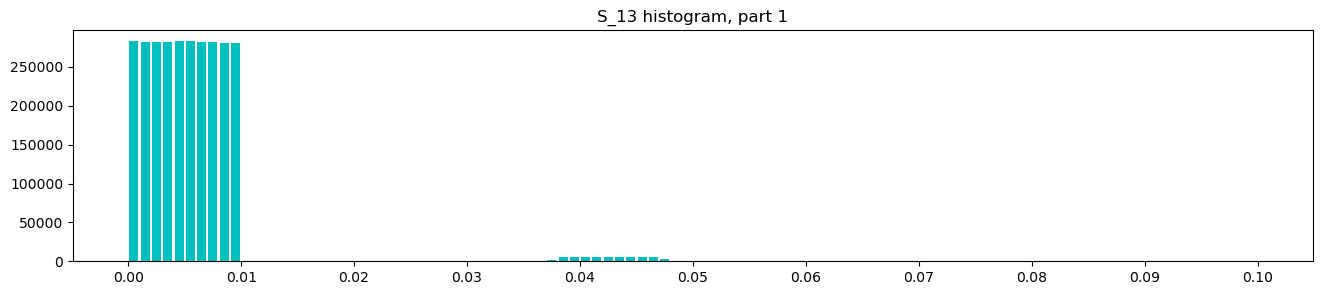

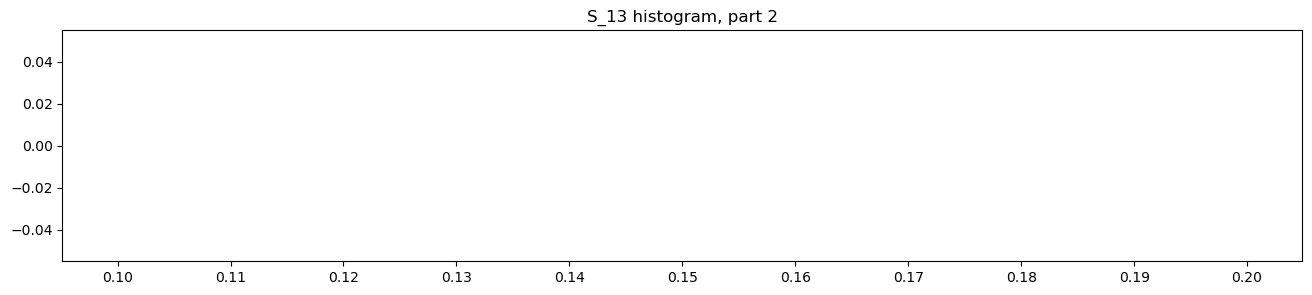

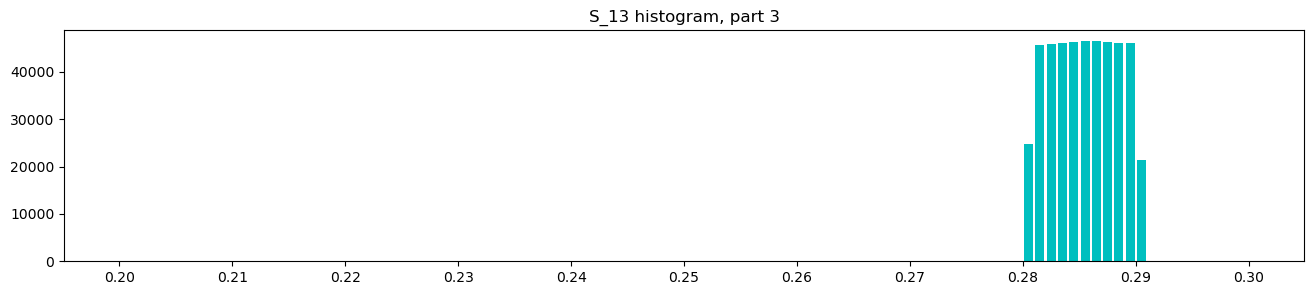

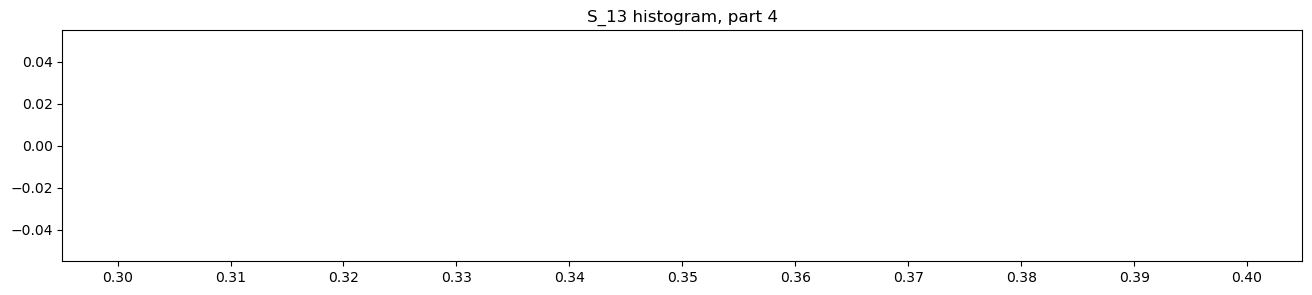

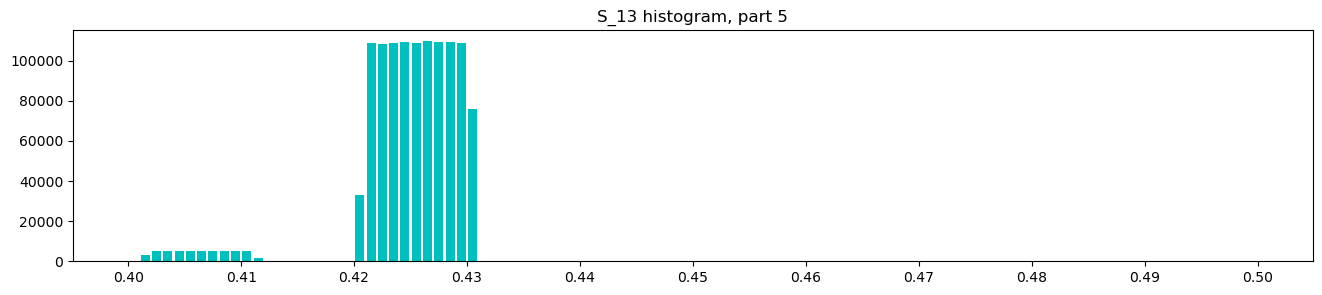

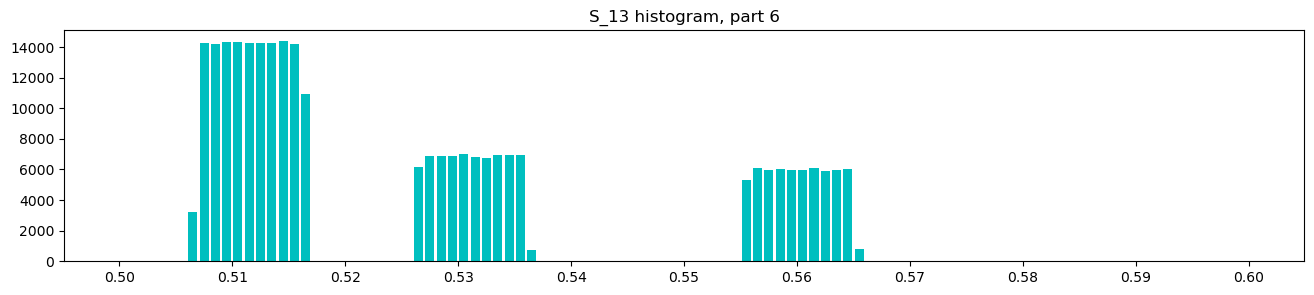

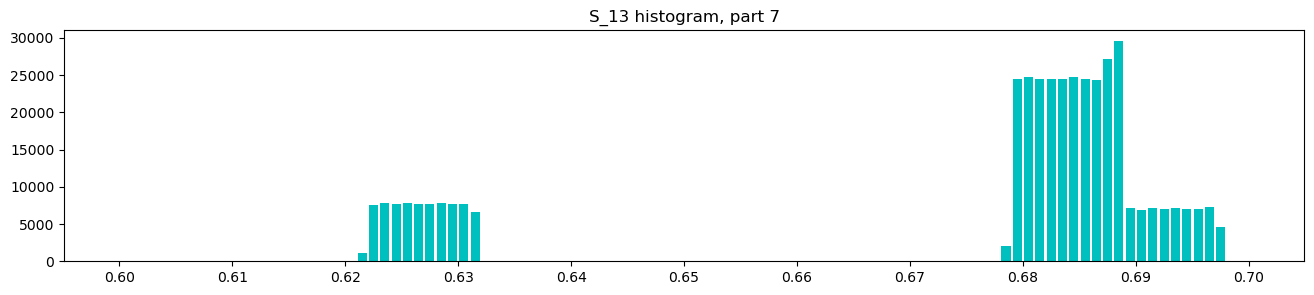

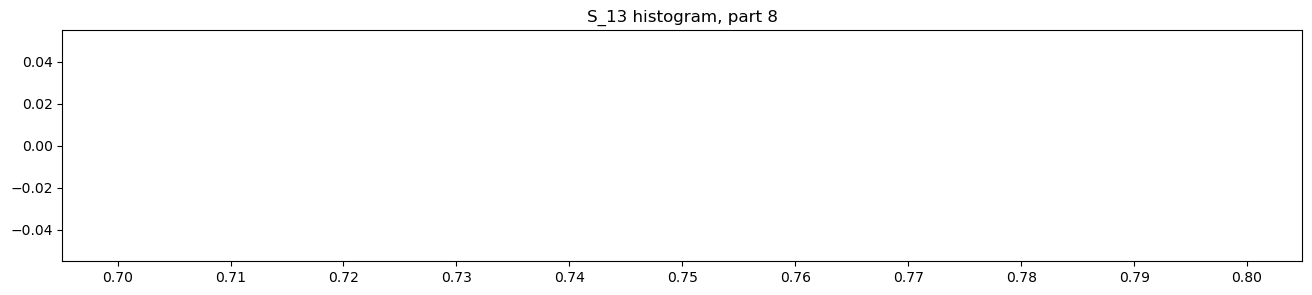

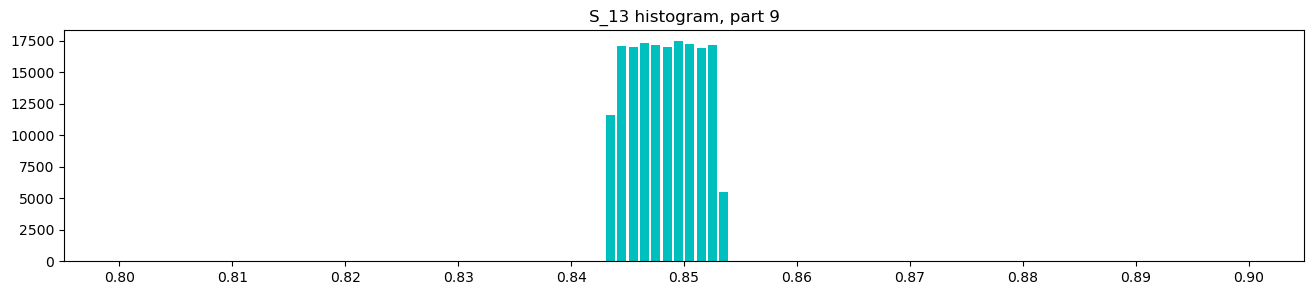

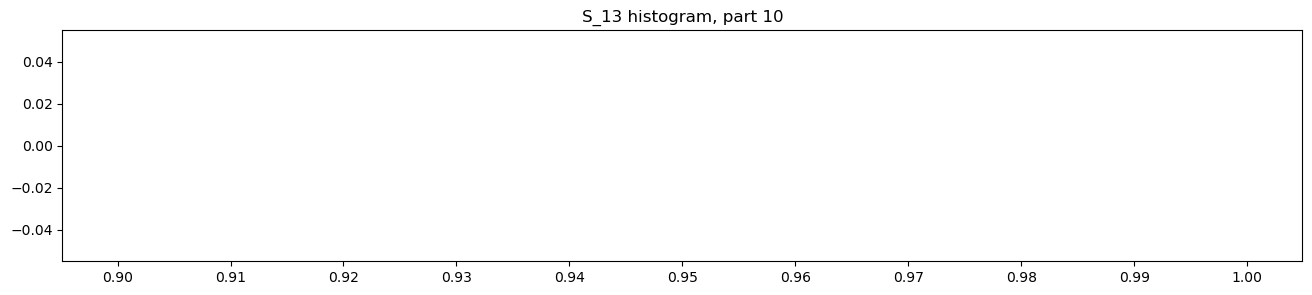

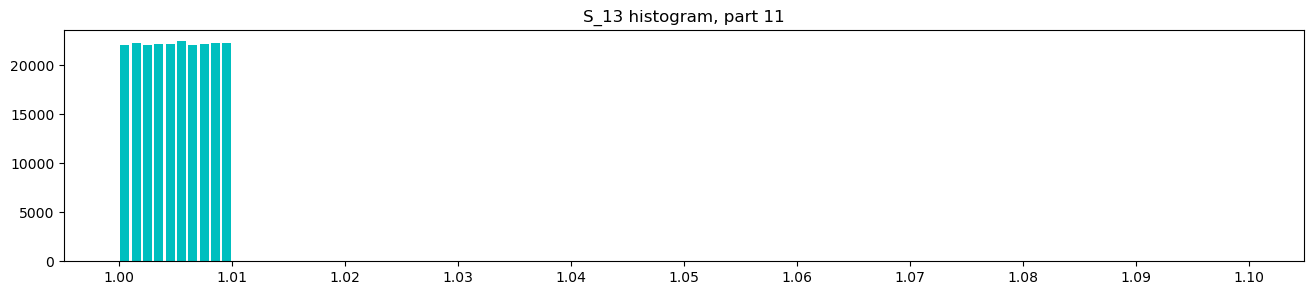

In [14]:
y = train_all_df.S_13
for i in np.linspace(0, 1, 11):
    plt.figure(figsize=(16, 3))
    plt.hist(y, bins=np.linspace(i, i+0.1, 101), rwidth=0.8, color='c')
    plt.xticks(np.linspace(i, i+0.1, 11))
    plt.title(f"S_13 histogram, part {int(i*10+1)}")
    plt.show()